In [88]:
import PyDSTool as pdt
import numpy as np
import networkx as nx
from random import shuffle
import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt
from pydivest.macro_model.integrate_equations_aggregate import IntegrateEquationsAggregate as Model
%matplotlib inline

In [90]:
# investment_decisions:

nopinions = [50, 50]

# Parameters:

phi, b_d = 0.5, 3.

input_parameters = {'b_c': 1., 'phi': .5, 'tau': 1.,
                    'eps': 0.05, 'b_d': 3, 'e': 1.,
                    'b_r0': 0.1,
                    'possible_cue_orders': [[0], [1]],
                    'xi': .05, 'beta': 0.06,
                    'L': 100., 'C': 1., 'G_0': 500000.,
                    'campaign': False, 'learning': True,
                    'interaction': 1, 'test': False,
                    'R_depletion': True}

# investment_decisions
opinions = []
for i, n in enumerate(nopinions):
    opinions.append(np.full((n), i, dtype='I'))
opinions = [item for sublist in opinions for item in sublist]
shuffle(opinions)

# network:
N = sum(nopinions)
p = .2

while True:
    net = nx.erdos_renyi_graph(N, p)
    if len(list(net)) > 1:
        break
adjacency_matrix = nx.adj_matrix(net).toarray()

# investment
clean_investment = np.ones(N)
dirty_investment = np.ones(N)

init_conditions = (adjacency_matrix, opinions,
                   clean_investment, dirty_investment)
m = Model(*init_conditions, **input_parameters)

In [93]:
DSargs = pdt.args(name='aggregated_approximation')
v_e, v_pi, v_tau = sp.symbols('v_e v_pi v_tau')
v_K_cc, v_K_cd, v_K_dc, v_K_dd = sp.symbols('K_cc K_cd K_dc K_dd')
v_subs = {m.e: v_e, m.pi: v_pi, m.tau: v_tau,
          m.Kcc: v_K_cc, m.Kcd: v_K_cd, 
          m.Kdc: v_K_dc, m.Kdd: v_K_dd}

equations = {m.var_symbols[i]: str(m.rhs_raw[i].subs(v_subs)) for i in range(len(m.var_names))}

equations_updated = {}
for (symbol, value) in equations.items():
    if symbol in v_subs.keys():
        equations_updated[str(v_subs[symbol])] = value
    else:
        equations_updated[str(symbol)] = value
        


params_updated = {}
for (symbol, value) in m.list_parameters().items():
    if symbol in v_subs.keys():
        params_updated[str(v_subs[symbol])] = value
    else:
        params_updated[str(symbol)] = value



initial_conditions = {}
for (symbol, value) in m.list_initial_conditions().items():
    if symbol in v_subs.keys():
        initial_conditions[str(v_subs[symbol])] = value
    else:
        initial_conditions[str(symbol)] = value   
    

del equations_updated['G']
del initial_conditions['G']

params_updated['G'] = m.p_G_0
#params_updated['xi'] = 0.01
#params_updated['epsilon'] = 0.05
#params_updated['phi'] = .5

initial_conditions['C'] = 1

print(params_updated)

DSargs.pars = params_updated
DSargs.varspecs = equations_updated
DSargs.ics = initial_conditions
DSargs.tdata = [0, 300]
DSargs.algparams = {'init_step': 0.2}

{'b_c': 1.0, 'b_d': 3.0, 'b_R': 0.1, 'v_e': 1.0, 's': 0.23, 'delta': 0.06, 'v_pi': 0.5, 'kappa_c': 0.5, 'kappa_d': 0.5, 'xi': 0.05, 'g_0': 5000.0, 'p': 1.0, 'G_0': 500000.0, 'P': 100.0, 'epsilon': 0.05, 'phi': 0.5, 'v_tau': 1.0, 'k': 9.82, 'N': 1.0, 'G': 500000.0}


In [94]:
ode = pdt.Generator.Vode_ODEsystem(DSargs)

In [95]:
traj = ode.compute('some name?')

In [96]:
pts = traj.sample(dt=1.)

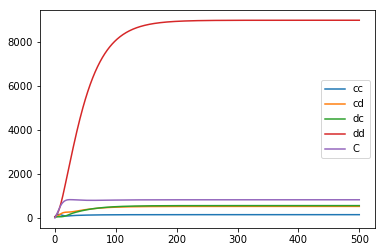

In [97]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(pts['t'], pts['K_cc'], label='cc')
ax.plot(pts['t'], pts['K_cd'], label='cd')
ax.plot(pts['t'], pts['K_dc'], label='dc')
ax.plot(pts['t'], pts['K_dd'], label='dd')
ax.plot(pts['t'], pts['C'], label='C')
plt.legend()


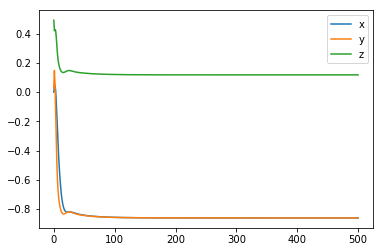

In [98]:
fig = plt.figure()
ax = fig.add_subplot(111)
#ax.plot(pts['t'], pts['K_cc'], label='cc')
ax.plot(pts['t'], pts['x'], label='x')
ax.plot(pts['t'], pts['y'], label='y')
ax.plot(pts['t'], pts['z'], label='z')
plt.legend()

In [99]:
ode.set(ics=pts[-1])

In [100]:
PC = pdt.ContClass(ode)
PCargs = pdt.args(name='EQ1', type='EP-C')
PCargs.freepars = ['xi']
PCargs.MaxNumPoints = 800
PCargs.MaxStepSize = 2
PCargs.MinStepSize = 1e-10
PCargs.StepSize = 2e-3
PCargs.SaveEigen = True
PCargs.LocBifPoints = 'LP'

In [101]:
PC.newCurve(PCargs)
PC['EQ1'].forward()

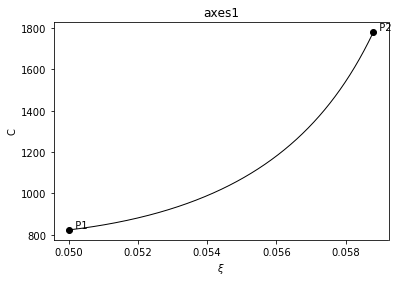

In [102]:
fig = plt.figure()
ax = fig.add_subplot(111)
PC['EQ1'].display(stability=True)
ax.set_xlabel(r'$\xi$')

In [103]:
PC['EQ1'].forward()

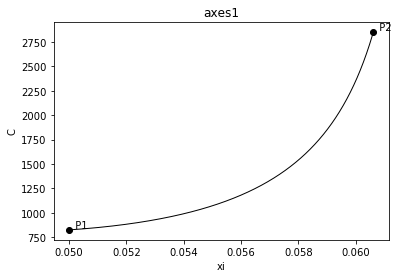

In [104]:
fig2 = plt.figure()
ax1 = fig2.add_subplot(111)
ax1.set_yscale('log')
thing = PC['EQ1'].display(stability=True)

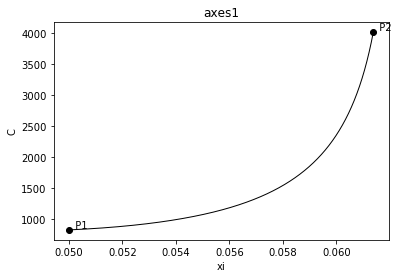

In [106]:
PC['EQ1'].forward()
fig2 = plt.figure()
ax1 = fig2.add_subplot(111)
ax1.set_yscale('log')
thing = PC['EQ1'].display(stability=True)

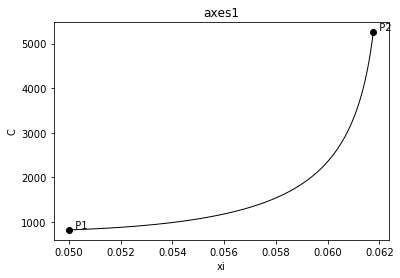

In [107]:
PC['EQ1'].forward()
fig2 = plt.figure()
ax1 = fig2.add_subplot(111)
ax1.set_yscale('log')
thing = PC['EQ1'].display(stability=True)

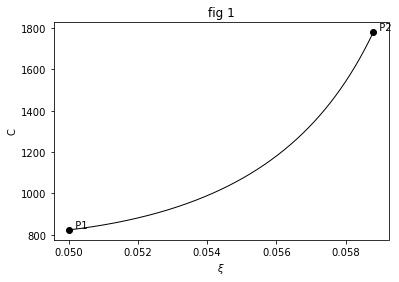

In [123]:
fig.get_axes()[0].set_title('fig 1')
fig

In [105]:
PCargs = pdt.args(name='SN1', type='EP-C', force=True)
PCargs.initpoint = 'EQ1:LP1'
PCargs.freepars = ['phi']
PCargs.MaxNumPoints = 2000
PCargs.MaxStepSize = 1
PCargs.MinStepSize = 1e-16
PCargs.StepSize = 2e-5
PCargs.SaveEigen = True
PCargs.LocBifPoints = 'LP'

In [71]:
PC.newCurve(PCargs)
PC['SN1'].forward()

LP Point found 
LP Point found 
LP Point found 
LP Point found 
LP Point found 
Test function going crazy:  <PyDSTool.PyCont.TestFunc.Fold_Tan object at 0x7f7d27dbacf8> 

LP Point found 
LP Point found 
LP Point found 
LP Point found 
LP Point found 
LP Point found 
LP Point found 


KeyboardInterrupt: 

In [ ]:
PC['SN1'].display(stability=True)